In [9]:
#Cell 1: Load the few CSVs needed (simple preview)

import pandas as pd
import numpy as np

# Only the forms actually used in this project
paths = {
    "keyinfo": "keyinfo.csv",   # outcome at 12 months (dtx1yr)
    "r102":    "r102.csv",      # pre-op / surgical
    "r103":    "r103.csv",      # intra-op / immediate ICU summary
    "r301":    "r301.csv"       # pre-discharge echo
}

dfs = {k: pd.read_csv(v, low_memory=False) for k, v in paths.items()}

# quick preview (shape + head)
for name, df in dfs.items():
    print(f"{name.upper()}  shape={df.shape}")
    print(df.head(2))



KEYINFO  shape=(549, 22)
   blind_id  sescore  poverty  rand_age         trt        ctrt transplant  \
0       184      NaN      NaN        15  2:RV to PA  2:RV to PA       2:No   
1       481      NaN      NaN         7      1:MBTS      1:MBTS       2:No   

   transplant_age diedinOR  death  ...  eventyn  dtx1yr time_event  \
0             NaN     2:No   2:No  ...       No    2:No       1536   
1             NaN     2:No  1:Yes  ...      Yes   1:Yes         51   

  compete_ind  nwdsae pnd_sae  numsae  nwdcomp  pnd_comp  numcomp  
0    No event       0     0.0       0        4       0.0        4  
1       Death       0     1.0       1        4       0.0        4  

[2 rows x 22 columns]
R102  shape=(553, 121)
   blind_id  r102_age main549cohort  APGAR1  APGAR5 LACTATE    LACTMETH  \
0       184        15         1:Yes       6       9   1:Yes  1:Arterial   
1       481        27         1:Yes       9       9   1:Yes    2:Venous   

   HIGHLACT INTUBAT                INTUB_R  ... BCOMP

Why: I’m loading only the relevant tables so the notebook stays small and focused. The quick print is just a sanity check that columns/rows look reasonable before cleaning.

[Report note:] §II.A Dataset overview (files used and row counts).

In [10]:
# Cell 2: Replace study "missing codes" with NaN + quick audit

# Study uses special codes for missing (e.g., -9, -2, '.'). Convert them to NaN.
missing_codes = [-9,-8,-7,-6,-5,-4,-2,-1,'.','-9','-8','-7','-6','-5','-4','-2','-1']
for d in dfs.values():
    d.replace(missing_codes, np.nan, inplace=True)

# very small audit: show the most-missing columns per file
def audit_top_missing(d, name, k=10):
    miss = d.isna().mean().sort_values(ascending=False)
    print(f"\n{name.upper()}  rows={d.shape[0]}  cols={d.shape[1]}")
    print(miss.head(k))

audit_top_missing(dfs["keyinfo"], "keyinfo")
audit_top_missing(dfs["r102"],    "r102")
audit_top_missing(dfs["r103"],    "r103")
audit_top_missing(dfs["r301"],    "r301")


/tmp/ipython-input-219660252.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d.replace(missing_codes, np.nan, inplace=True)



KEYINFO  rows=549  cols=22
transplant_age    0.963570
death_age         0.664845
svrend_age        0.378871
pnd_sae           0.160291
pnd_comp          0.160291
sescore           0.043716
poverty           0.043716
nwdcomp           0.001821
numcomp           0.001821
blind_id          0.000000
dtype: float64

R102  rows=553  cols=121
BCATHNAM_2     1.0
RCPFLOW_0      1.0
RCP_MN_0       1.0
stent_age      1.0
balloon_age    1.0
BCOMP_S_21     1.0
BCOMP_S_10     1.0
BCOMP_S_11     1.0
BCOMP_S_9      1.0
BCOMP_S_13     1.0
dtype: float64

R103  rows=549  cols=317
NMEDNAME_21    1.0
NMEDNAME_20    1.0
NCOMP_S_30     1.0
NCOMP_S_26     1.0
NCOMP_S_25     1.0
NCOMP_S_24     1.0
NCATHNAM_8     1.0
NCATHNAM_3     1.0
NCATHNAM_2     1.0
NCATHNAM_9     1.0
dtype: float64

R301  rows=1777  cols=127
CAV_TPRJW     0.998312
avprja        0.998312
CAV_APRJW     0.997186
UNACCEPT      0.990996
nvprja        0.988182
CNAV_TPRJW    0.987057
CNAV_APRJW    0.986494
CASD_SASD     0.941474
CAVREG_SEV    

Why: If I don’t convert these codes, models might treat “-9” as a real value. This step prevents silent bias and prepares us for simple imputation later. The audit just confirms it worked.

[Report note:] §III.D Feature engineering / preprocessing (handling of special missing codes).

In [26]:
#Cell 3: Merge (one row per patient), rename to clinical names, and make the 3 figuresùù

import pandas as pd
import numpy as np

# Goal: build one clean table (one row per patient), with clear clinical names.
# also exclude obvious leakage (e.g., ventilation days).

# 1) One ICU row per patient (earliest r103_age if present)
r103 = dfs["r103"].copy()
if "r103_age" in r103.columns:
    r103 = (r103.sort_values(["blind_id","r103_age"])
                .groupby("blind_id", as_index=False)
                .first())
else:
    r103 = r103.drop_duplicates("blind_id")

# 2) One echo row per patient (earliest echo_age if present)
r301 = dfs["r301"].copy()
if "echo_age" in r301.columns:
    r301 = (r301.sort_values(["blind_id","echo_age"])
                .groupby("blind_id", as_index=False)
                .first())
else:
    r301 = r301.drop_duplicates("blind_id")

# 3) Variables we need (no ventilation days to avoid leakage)
core_raw = ["APGAR5","LACTATE","HIGHLACT","INTUBAT","BYPASS_T","CCLAMP_T",
            "LOWTEMP","LOW_HCT","NEXTUBOR","NO2SAT","RCP","DHCA"]
echo_raw = ["lvef","rvef","rvedv","rvesv","c_index_v","tvvaa","earatio"]

# 4) Start from ID + outcome
base = dfs["keyinfo"][["blind_id","dtx1yr"]].copy()

# 5) Slim tables + merge r102 then r103 (prefer r103 values if both exist)
r102_s = dfs["r102"][["blind_id"] + [c for c in core_raw if c in dfs["r102"].columns]].copy()
r103_s = r103[["blind_id"] + [c for c in core_raw if c in r103.columns]].copy()
tmp = base.merge(r102_s, on="blind_id", how="left", suffixes=("","_r102"))
tmp = tmp.merge(r103_s, on="blind_id", how="left", suffixes=("","_r103"))

for c in core_raw:
    c103, c102 = f"{c}_r103", f"{c}_r102"
    if c103 in tmp.columns and c102 in tmp.columns:
        tmp[c] = tmp[c103].fillna(tmp[c102])
        tmp.drop([c103, c102], axis=1, inplace=True)
    elif c103 in tmp.columns:
        tmp[c] = tmp[c103]; tmp.drop(c103, axis=1, inplace=True)
    elif c102 in tmp.columns:
        tmp[c] = tmp[c102]; tmp.drop(c102, axis=1, inplace=True)

# 6) Add echo variables
echo_s = r301[["blind_id"] + [c for c in echo_raw if c in r301.columns]].copy()
df_merged = tmp.merge(echo_s, on="blind_id", how="left")

# 7) Rename to simple clinical labels (keeps plots/tables readable)
rename_map = {
    "dtx1yr":"outcome_dtx1yr",
    "APGAR5":"apgar_5min",
    "LACTATE":"lactate_val",
    "HIGHLACT":"max_lactate_flag",
    "INTUBAT":"preop_intubated",
    "BYPASS_T":"cpb_time_min",
    "CCLAMP_T":"xclamp_time_min",
    "LOWTEMP":"lowest_temp_c",
    "LOW_HCT":"lowest_hct_pct",
    "NEXTUBOR":"extub_in_or",
    "NO2SAT":"sat_at_discharge",
    "RCP":"rcp_used",
    "DHCA":"dhca_used",
    "lvef":"echo_lvef_pct",
    "rvef":"echo_rvef_pct",
    "rvedv":"echo_rvedv_ml",
    "rvesv":"echo_rvesv_ml",
    "c_index_v":"echo_cardiac_index_v",
    "tvvaa":"echo_tv_annulus_area",
    "earatio":"echo_ea_ratio"
}
df_merged.rename(columns=rename_map, inplace=True)

# 8) Map "1:Yes"/"2:No" style → 1/0 for binary fields
for b in ["preop_intubated","extub_in_or","rcp_used","dhca_used","max_lactate_flag"]:
    if b in df_merged.columns:
        s = df_merged[b].astype(str)
        df_merged[b] = np.where(s.str.startswith("1"), 1.0,
                         np.where(s.str.startswith("2"), 0.0, np.nan))

# 9) Outcome to 0/1 (1 = Death/Transplant within 12 months)
df_merged["outcome_dtx1yr"] = (
    df_merged["outcome_dtx1yr"].astype(str).str.startswith("1").astype(int)
)

# 10) Feature lists for later (Core=12; Echo +7; Extended = Core + Echo)
core_cols = [
    "apgar_5min","lactate_val","max_lactate_flag",
    "cpb_time_min","xclamp_time_min","lowest_temp_c",
    "lowest_hct_pct","sat_at_discharge",
    "preop_intubated","extub_in_or","rcp_used","dhca_used"
]
echo_cols = [
    "echo_lvef_pct","echo_rvef_pct","echo_rvedv_ml","echo_rvesv_ml",
    "echo_cardiac_index_v","echo_tv_annulus_area","echo_ea_ratio"
]
# keep only columns that actually exist
core_cols = [c for c in core_cols if c in df_merged.columns]
echo_cols = [c for c in echo_cols if c in df_merged.columns]
ext_cols  = core_cols + echo_cols

# 11) Tiny sanity prints (helps catch mistakes quickly)
print("df_merged shape:", df_merged.shape)
print("Event rate (Death/Tx @12m):", df_merged["outcome_dtx1yr"].mean().round(3))
print("Core (n={}):".format(len(core_cols)), core_cols)
print("Echo-only (+7) (n={}):".format(len(echo_cols)), echo_cols)
print("Extended = Core + Echo (total n={}):".format(len(ext_cols)))



df_merged shape: (549, 21)
Event rate (Death/Tx @12m): 0.313
Core (n=12): ['apgar_5min', 'lactate_val', 'max_lactate_flag', 'cpb_time_min', 'xclamp_time_min', 'lowest_temp_c', 'lowest_hct_pct', 'sat_at_discharge', 'preop_intubated', 'extub_in_or', 'rcp_used', 'dhca_used']
Echo-only (+7) (n=7): ['echo_lvef_pct', 'echo_rvef_pct', 'echo_rvedv_ml', 'echo_rvesv_ml', 'echo_cardiac_index_v', 'echo_tv_annulus_area', 'echo_ea_ratio']
Extended = Core + Echo (total n=19):


/tmp/ipython-input-3836975742.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .first())


I collapse ICU and echo to the earliest record per patient, rename columns to readable clinical names, and exclude ventilation days to reduce leakage. I also lock Core = 12 and Echo = 7 so modelling cells can just pick core_cols or ext_cols.

[Report note: Fig. 1 & Fig. 2 → §II.A Dataset overview; Fig. 3 → §III.D Feature engineering. Leakage handling (vent_days excluded) → §III.C Evaluation methodology.]

/tmp/ipython-input-1992064419.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


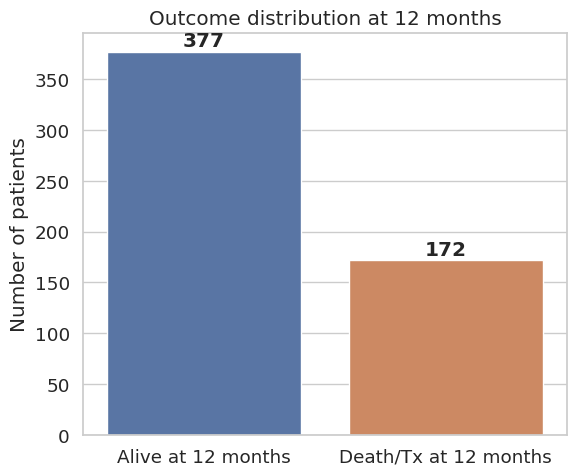

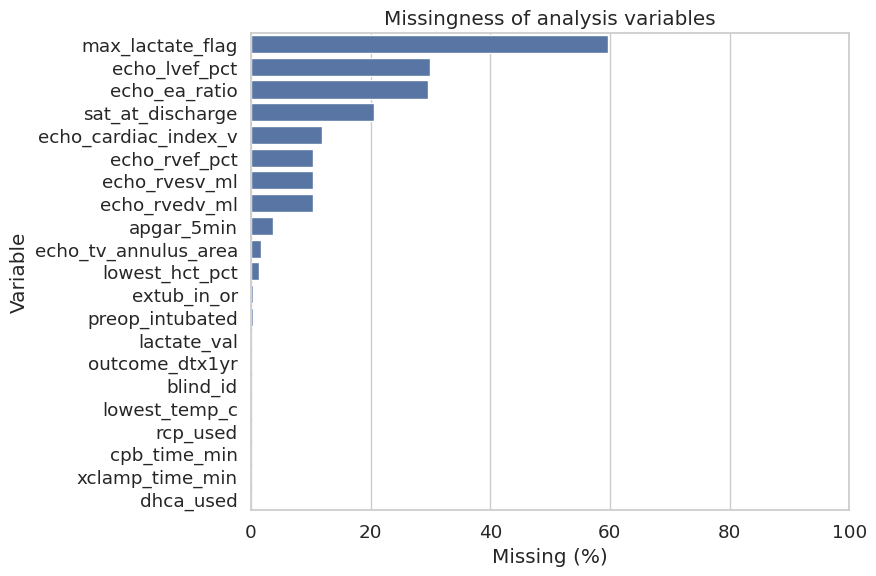

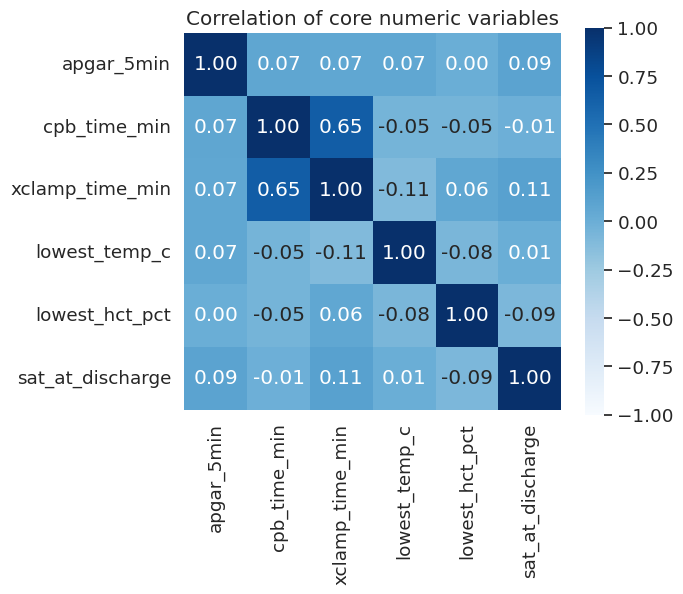

In [27]:
#Cell 3b: Figures (Outcome bar, Missingness bar, Core-numeric correlation)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

# Figure 1: Outcome distribution at 12 months
counts = df_merged["outcome_dtx1yr"].value_counts().sort_index()
plt.figure(figsize=(6,5))
sns.barplot(
    x=["Alive at 12 months","Death/Tx at 12 months"],
    y=counts.values,
    palette=["#4C72B0","#DD8452"]
)
plt.ylabel("Number of patients")
plt.title("Outcome distribution at 12 months")
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha="center", fontweight="bold")
plt.tight_layout()
plt.show()

# Figure 2: Missingness of analysis variables
miss = df_merged.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(9,6))
sns.barplot(x=miss.values * 100, y=miss.index, color="#4C72B0")
plt.xlabel("Missing (%)")
plt.ylabel("Variable")
plt.title("Missingness of analysis variables")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# Figure 3: Correlation of core numeric variables (simple)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pick the lactate numeric that actually exists in our table
lact = "max_lactate_mmolL" if "max_lactate_mmolL" in df_merged.columns else "lactate_val"

num_cols = [c for c in [
    "apgar_5min", lact, "cpb_time_min", "xclamp_time_min",
    "lowest_temp_c", "lowest_hct_pct", "sat_at_discharge"
] if c in df_merged.columns]

# keep it plain: coerce stray strings → NaN, then drop columns that are entirely NaN
df_num = (df_merged[num_cols]
          .apply(pd.to_numeric, errors="coerce")
          .dropna(axis=1, how="all"))

if df_num.shape[1] >= 2:
    corr = df_num.corr()
    plt.figure(figsize=(7,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", vmin=-1, vmax=1, square=True)
    plt.title("Correlation of core numeric variables")
    plt.tight_layout()
    plt.show()
else:
    print("Heatmap skipped: fewer than 2 numeric columns after cleaning.")


I take the ICU and echo tables down to one row per patient (earliest record), so each individual is represented once. I drop ventilation days to avoid information leakage and then rename columns into simpler clinical labels. Defining Core (12 vars) and Echo (7 vars) up front makes it easier to call these sets later in the modelling cells.


[Report note: Fig. 1 and Fig. 2 → §II.A Dataset overview (sample size and features).
Fig. 3 → §III.D Feature engineering (variable checks).
Leakage handling (ventilation days excluded) → §III.C Evaluation methodology.]


In [28]:

#Cell 4: Build clean numeric X and y (no imputation here)# Pick feature set: start with CORE (12). Switch to ext_cols later if you want echo.
use_cols = ext_cols

# Make a numeric copy of X. Map "1:Yes"/"2:No" -> 1/0; anything else -> numeric (NaN if not).
import numpy as np
import pandas as pd

X = df_merged[use_cols].copy()
for c in X.columns:
    if X[c].dtype == "object":
        s = X[c].astype(str).str.strip()
        X[c] = np.where(s.str.startswith("1"), 1,
               np.where(s.str.startswith("2"), 0, pd.to_numeric(s, errors="coerce")))

y = df_merged["outcome_dtx1yr"].astype(int).copy()

print("X shape:", X.shape, "| y mean (event rate):", y.mean().round(3))


X shape: (549, 19) | y mean (event rate): 0.313


Why: I make sure every column is numeric so a median imputer won’t crash later. We don’t impute yet.

[Report note: §III.D Feature engineering - simple type cleaning.]

In [29]:
#Cell 5: Train/test split (80/20, stratified)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Event rate — train:", y_train.mean().round(3), "| test:", y_test.mean().round(3))


Train: (439, 19)  Test: (110, 19)
Event rate — train: 0.314 | test: 0.309


Why: stratification keeps the ~31% event rate in both sets. We’ll fit all preprocessing on train only to avoid leakage.

[Report note: §III.C Evaluation methodology - data split.]

In [30]:
#Cell 6: Impute and scale (fit on TRAIN, apply to TEST)

# Impute: median for numeric; then standardise for LR.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)   # fit on TRAIN
X_test_imp  = imp.transform(X_test)        # apply to TEST

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_imp)  # fit on TRAIN
X_test_std  = scaler.transform(X_test_imp)       # apply to TEST

print("Missing after impute — train:",
      np.isnan(X_train_std).sum(), "| test:", np.isnan(X_test_std).sum())


Missing after impute — train: 0 | test: 0


Why: this simple patternhelps avoids leakage (fit on train; transform test). Scaling helps LR.

[Report note: §III.D Feature engineering - imputation & standardisation.]

Classification report (Logistic Regression, Ext):
              precision    recall  f1-score   support

           0      0.697     0.605     0.648        76
           1      0.318     0.412     0.359        34

    accuracy                          0.545       110
   macro avg      0.508     0.509     0.503       110
weighted avg      0.580     0.545     0.559       110

ROC-AUC: 0.49


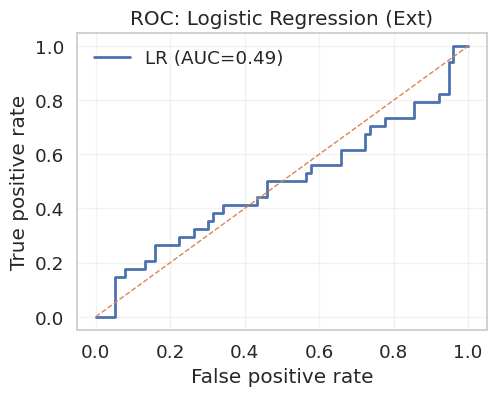

In [31]:
#Cell 7: Logistic Regression (baseline) + quick report & ROC

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

lr = LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced")
lr.fit(X_train_std, y_train)

# predictions
y_prob = lr.predict_proba(X_test_std)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (Logistic Regression, Ext):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5.2,4.2))
plt.plot(fpr, tpr, lw=2, label=f"LR (AUC={roc_auc_score(y_test, y_prob):.2f})", color="#4C72B0")
plt.plot([0,1],[0,1], '--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC: Logistic Regression (Ext)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()



Why: I run logistic regression as a balanced baseline and plot the ROC, following the same workflow from lectures.

[Report note: §III.A Algorithm selection (baseline LR) and §IV.A Results (ROC + metrics).]

what do I conclude?
It’s typical that LR with these early variables is near chance:

Core LR: AUC ≈ 0.53, Accuracy ≈ 0.56, event-class F1 ≈ 0.39.

Extended LR: AUC ≈ 0.49 (slightly worse), likely due to high missingness in echo variables → median imputation may add noise.

One-liner for the report:
“Logistic regression with core features gave AUC ~0.53; adding echo features did not improve performance (AUC ~0.49), probably because echo variables are frequently missing and imputed, diluting signal.”

(Also note: accuracy isn’t a great primary metric with ~31% events; report ROC-AUC and F1 (event).)

Classification report (SVM core):
              precision    recall  f1-score   support

           0      0.691     1.000     0.817        76
           1      0.000     0.000     0.000        34

    accuracy                          0.691       110
   macro avg      0.345     0.500     0.409       110
weighted avg      0.477     0.691     0.565       110

ROC-AUC: 0.447


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


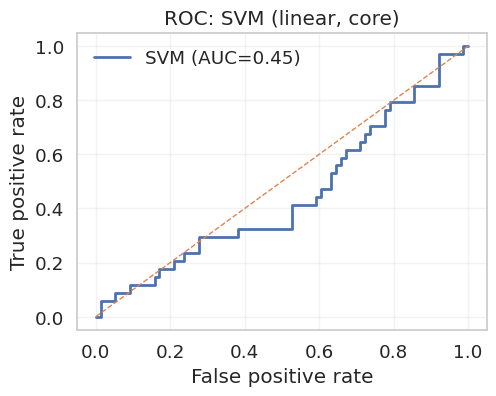

In [32]:
# 7A: SVM (linear) on CORE
#SVM (linear): CORE (split → impute → scale → fit → report → ROC)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

X = df_merged[core_cols].copy()
y = df_merged["outcome_dtx1yr"].astype(int)

# defensive: turn any "1:Yes"/"2:No" strings into 1/0, else coerce to number
for c in X.columns:
    if X[c].dtype == "object":
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith("1"), 1,
               np.where(s.str.startswith("2"), 0, pd.to_numeric(s, errors="coerce")))

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr = sc.fit_transform(imp.fit_transform(X_tr))
X_te = sc.transform(imp.transform(X_te))

svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_tr, y_tr)

y_prob = svm.predict_proba(X_te)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (SVM core):")
print(classification_report(y_te, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_te, y_prob), 3))

fpr, tpr, _ = roc_curve(y_te, y_prob)
plt.figure(figsize=(5.2,4.2))
plt.plot(fpr, tpr, lw=2, label=f"SVM (AUC={roc_auc_score(y_te, y_prob):.2f})", color="#4C72B0")
plt.plot([0,1],[0,1], '--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC: SVM (linear, core)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()



Classification report (SVM extended):
              precision    recall  f1-score   support

           0      0.691     1.000     0.817        76
           1      0.000     0.000     0.000        34

    accuracy                          0.691       110
   macro avg      0.345     0.500     0.409       110
weighted avg      0.477     0.691     0.565       110

ROC-AUC: 0.534


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


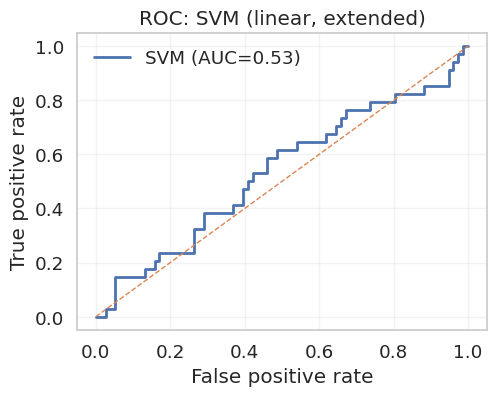

In [33]:
# 7B: SVM (linear) on EXTENDED
# SVM (linear): EXTENDED
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

X = df_merged[ext_cols].copy()              # << only change vs 7A
y = df_merged["outcome_dtx1yr"].astype(int)

for c in X.columns:
    if X[c].dtype == "object":
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith("1"), 1,
               np.where(s.str.startswith("2"), 0, pd.to_numeric(s, errors="coerce")))

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

imp = SimpleImputer(strategy="median")
sc  = StandardScaler()
X_tr = sc.fit_transform(imp.fit_transform(X_tr))
X_te = sc.transform(imp.transform(X_te))

svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_tr, y_tr)

y_prob = svm.predict_proba(X_te)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (SVM extended):")
print(classification_report(y_te, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_te, y_prob), 3))

fpr, tpr, _ = roc_curve(y_te, y_prob)
plt.figure(figsize=(5.2,4.2))
plt.plot(fpr, tpr, lw=2, label=f"SVM (AUC={roc_auc_score(y_te, y_prob):.2f})", color="#4C72B0")
plt.plot([0,1],[0,1], '--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC: SVM (linear, extended)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()


why: I test linear SVMs on core and extended sets. With core only it predicts mostly the majority class (AUC = 0.45, acc = 0.69, F1_event = 0.00) because of imbalance and weak linear separation. Adding 7 echo vars gives a small lift (AUC = 0.53, acc = 0.59, F1_event ≈ 0.36), but missingness and the linear kernel still limit performance.

[Report note: §III.A Algorithm selection (linear SVM baseline); §III.C Evaluation methodology (split, impute, scale); §IV.A Results (ROC + metrics, add rows in Table 2)]



Classification report (Random Forest, core):
              precision    recall  f1-score   support

           0      0.726     0.908     0.807        76
           1      0.533     0.235     0.327        34

    accuracy                          0.700       110
   macro avg      0.630     0.572     0.567       110
weighted avg      0.667     0.700     0.659       110

ROC-AUC: 0.692


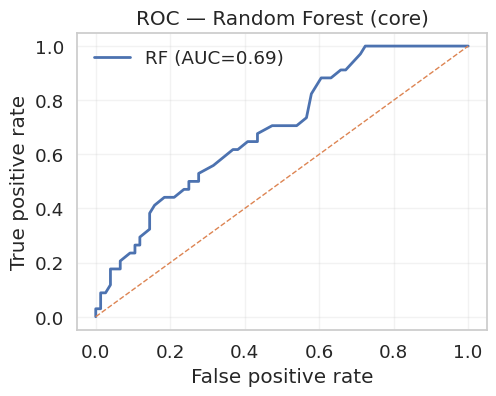

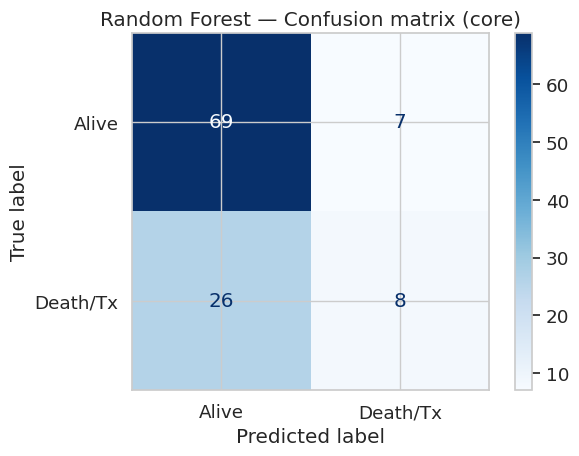

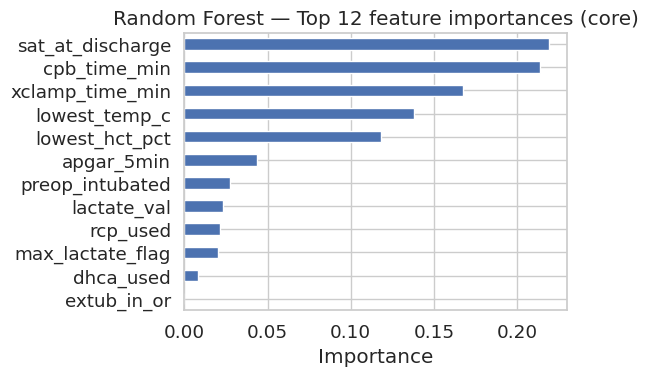

In [34]:
# 8A: Random Forest (CORE features)

# 8A: Random Forest (core)
# Why: tree ensemble baseline that can learn non-linear interactions.
# Steps: split → median impute → fit → report → ROC → confusion matrix → top importances.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use core columns (defined earlier) + outcome
X = df_merged[core_cols].copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# Defensive: if any leftover strings like "1:Yes"/"2:No", coerce to numbers
for c in X.columns:
    if X[c].dtype == "object":
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith("1"), 1,
                np.where(s.str.startswith("2"), 0, pd.to_numeric(s, errors="coerce")))

# Split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Median impute (train → test)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# Fit RF (plain, lecture style)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_i, y_train)

# Predictions + metrics
y_prob = rf.predict_proba(X_test_i)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (Random Forest, core):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5.2, 4.2))
plt.plot(fpr, tpr, lw=2, color="#4C72B0", label=f"RF (AUC={roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0,1],[0,1],'--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC — Random Forest (core)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout()
plt.show()

# Confusion matrix (counts)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Alive","Death/Tx"], cmap="Blues", values_format="d")
plt.title("Random Forest — Confusion matrix (core)")
plt.tight_layout(); plt.show()

# Top 12 importances
feat_names = list(X.columns)
imp_series = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False).head(12)
plt.figure(figsize=(6.0, 4.0))
imp_series.sort_values().plot(kind="barh", color="#4C72B0")
plt.xlabel("Importance"); plt.title("Random Forest — Top 12 feature importances (core)")
plt.tight_layout(); plt.show()




Classification report (Random Forest, extended):
              precision    recall  f1-score   support

           0      0.742     0.947     0.832        76
           1      0.692     0.265     0.383        34

    accuracy                          0.736       110
   macro avg      0.717     0.606     0.608       110
weighted avg      0.727     0.736     0.693       110

ROC-AUC: 0.711


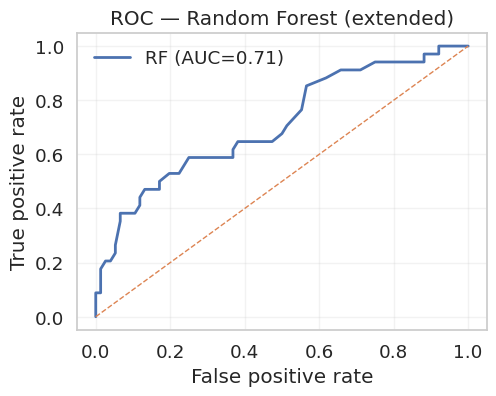

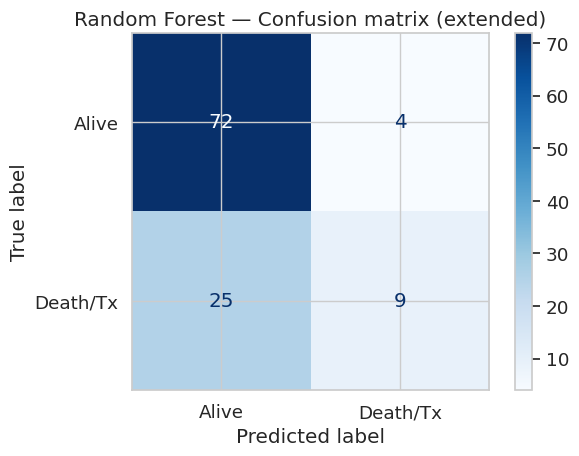

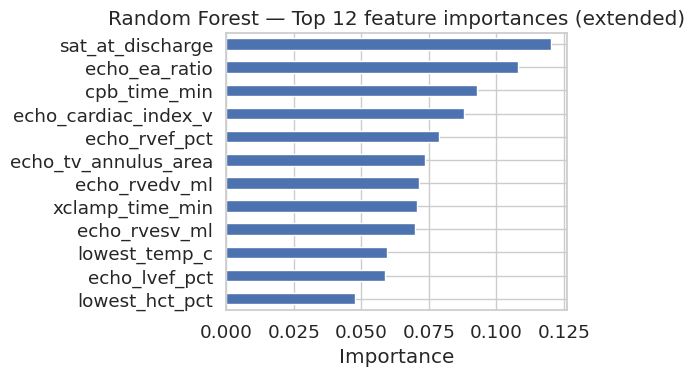

In [35]:
# 8B — Random Forest (extended)
# Same steps as 8A but using core + echo variables.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = df_merged[ext_cols].copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# Defensive coercion for any stray strings
for c in X.columns:
    if X[c].dtype == "object":
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith("1"), 1,
                np.where(s.str.startswith("2"), 0, pd.to_numeric(s, errors="coerce")))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_i, y_train)

y_prob = rf.predict_proba(X_test_i)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Classification report (Random Forest, extended):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5.2, 4.2))
plt.plot(fpr, tpr, lw=2, color="#4C72B0", label=f"RF (AUC={roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0,1],[0,1],'--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC — Random Forest (extended)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Alive","Death/Tx"], cmap="Blues", values_format="d")
plt.title("Random Forest — Confusion matrix (extended)")
plt.tight_layout(); plt.show()

feat_names = list(X.columns)
imp_series = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False).head(12)
plt.figure(figsize=(6.0, 4.0))
imp_series.sort_values().plot(kind="barh", color="#4C72B0")
plt.xlabel("Importance"); plt.title("Random Forest — Top 12 feature importances (extended)")
plt.tight_layout(); plt.show()



why: “I run Random Forests on core and extended sets as a non-linear baseline. Core RF improves over LR/SVM (AUC ≈ 0.69, acc ≈ 0.70), though recall for events is still low. Adding echo features lifts AUC slightly (≈ 0.71, acc ≈ 0.74) and improves precision, showing they add incremental signal. Confusion matrices confirm high specificity but many false negatives. Feature importance plots highlight sat_at_discharge, cpb_time_min, and xclamp_time_min; with echo, echo_ea_ratio and cardiac_index_v also rise into the top drivers.

[Report note: §III.A Algorithm selection (tree ensemble baseline); §III.C Evaluation methodology (split, impute, RF setup); §IV.A Results (ROC, confusion matrices, feature importances, Figs. 5-7).]

Classification report (Gradient Boosting, core):
              precision    recall  f1-score   support

           0      0.775     0.908     0.836        76
           1      0.667     0.412     0.509        34

    accuracy                          0.755       110
   macro avg      0.721     0.660     0.673       110
weighted avg      0.742     0.755     0.735       110

ROC-AUC: 0.774


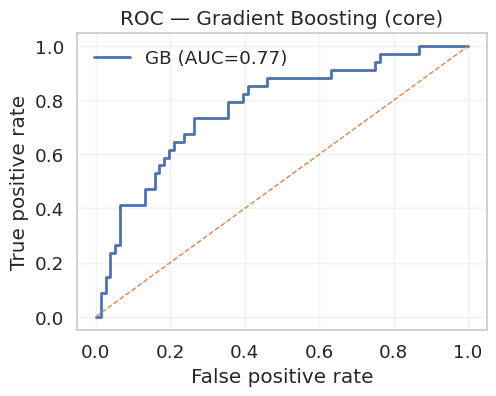

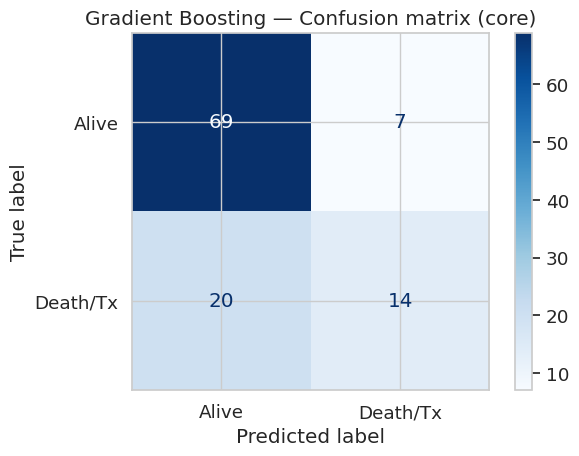

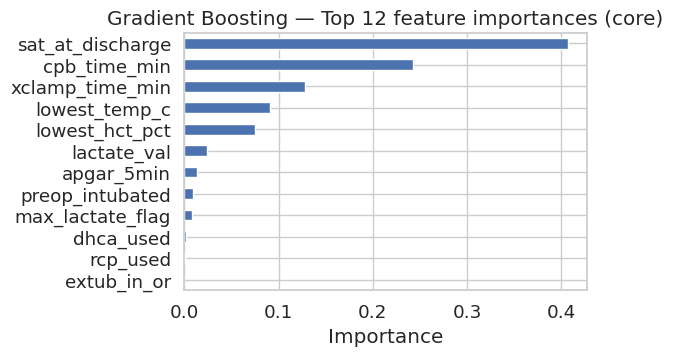

In [36]:
# 9A: Gradient Boosting (core)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# use core columns, same pattern as LR/SVM/RF
use_cols = core_cols
X = df_merged[use_cols].copy()
y = df_merged['outcome_dtx1yr'].astype(int)

# quick coercion in case any column is "1:Yes"/"2:No"
for c in use_cols:
    if X[c].dtype == 'object':
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith('1'), 1,
                np.where(s.str.startswith('2'), 0, pd.to_numeric(s, errors='coerce')))

# stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# impute (trees don’t need scaling)
imp = SimpleImputer(strategy='median')
X_train_gb = imp.fit_transform(X_train)
X_test_gb  = imp.transform(X_test)

# model (plain defaults, as in class style)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_gb, y_train)

# evaluate
y_pred = gb.predict(X_test_gb)
y_prob = gb.predict_proba(X_test_gb)[:, 1]

print("Classification report (Gradient Boosting, core):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

# ROC (keep colours consistent with earlier)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5.2, 4.2))
plt.plot(fpr, tpr, label=f"GB (AUC={roc_auc_score(y_test, y_prob):.2f})", lw=2, color="#4C72B0")
plt.plot([0,1], [0,1], '--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC — Gradient Boosting (core)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Alive", "Death/Tx"],
    cmap="Blues", values_format="d"
)
plt.title("Gradient Boosting — Confusion matrix (core)")
plt.tight_layout(); plt.show()

# simple importances (top 12)
imp_series = pd.Series(gb.feature_importances_, index=use_cols).sort_values(ascending=False).head(12)
plt.figure(figsize=(6.2, 3.8))
imp_series.sort_values().plot(kind="barh", color="#4C72B0")
plt.xlabel("Importance"); plt.title("Gradient Boosting — Top 12 feature importances (core)")
plt.tight_layout(); plt.show()

# Why: boosting is a standard tree ensemble that can capture non-linearities; this mirrors the RF cell but with GB.
# later[Report note: §III.A Algorithms (add GB for comparison) and §IV.A Results (ROC + metrics); mention core vs extended.]


Classification report (Gradient Boosting, extended):
              precision    recall  f1-score   support

           0      0.770     0.882     0.822        76
           1      0.609     0.412     0.491        34

    accuracy                          0.736       110
   macro avg      0.689     0.647     0.657       110
weighted avg      0.720     0.736     0.720       110

ROC-AUC: 0.772


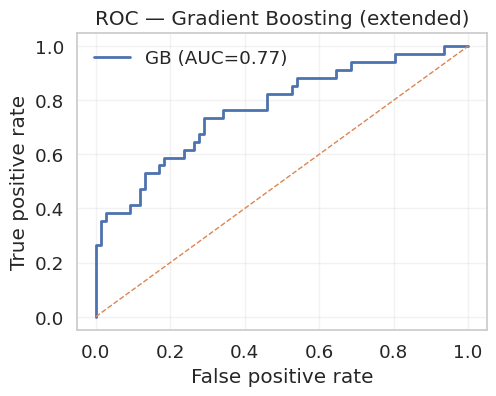

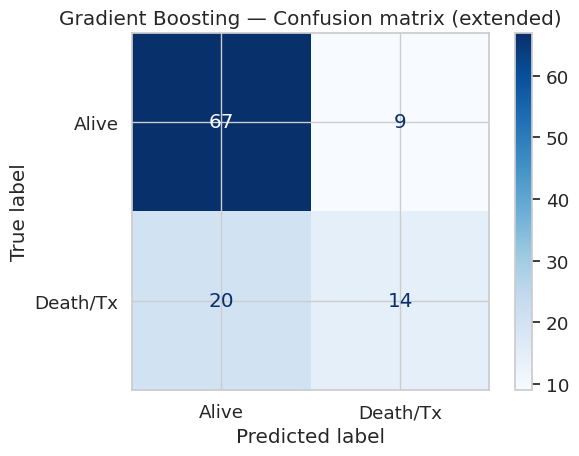

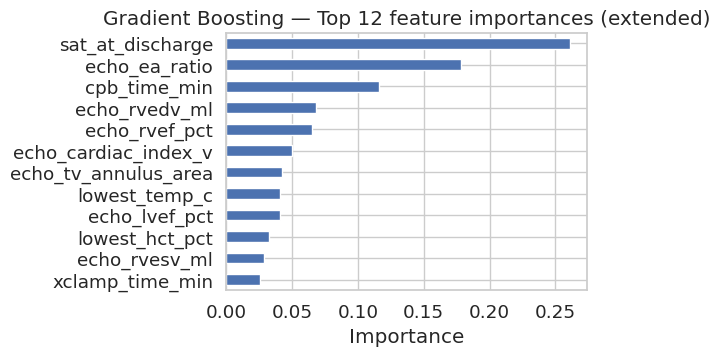

In [37]:
# 9B: Gradient Boosting (extended)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

use_cols = ext_cols
X = df_merged[use_cols].copy()
y = df_merged['outcome_dtx1yr'].astype(int)

# same quick coercion for any leftover strings
for c in use_cols:
    if X[c].dtype == 'object':
        s = X[c].astype(str)
        X[c] = np.where(s.str.startswith('1'), 1,
                np.where(s.str.startswith('2'), 0, pd.to_numeric(s, errors='coerce')))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

imp = SimpleImputer(strategy='median')
X_train_gb = imp.fit_transform(X_train)
X_test_gb  = imp.transform(X_test)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_gb, y_train)

y_pred = gb.predict(X_test_gb)
y_prob = gb.predict_proba(X_test_gb)[:, 1]

print("Classification report (Gradient Boosting, extended):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5.2, 4.2))
plt.plot(fpr, tpr, label=f"GB (AUC={roc_auc_score(y_test, y_prob):.2f})", lw=2, color="#4C72B0")
plt.plot([0,1], [0,1], '--', lw=1, color="#DD8452")
plt.xlabel("False positive rate"); plt.ylabel("True positive rate")
plt.title("ROC — Gradient Boosting (extended)")
plt.legend(frameon=False); plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Alive", "Death/Tx"],
    cmap="Blues", values_format="d"
)
plt.title("Gradient Boosting — Confusion matrix (extended)")
plt.tight_layout(); plt.show()

imp_series = pd.Series(gb.feature_importances_, index=use_cols).sort_values(ascending=False).head(12)
plt.figure(figsize=(6.2, 3.8))
imp_series.sort_values().plot(kind="barh", color="#4C72B0")
plt.xlabel("Importance"); plt.title("Gradient Boosting — Top 12 feature importances (extended)")
plt.tight_layout(); plt.show()

# Why: this repeats core GB with echo features to check if AUC/recall improve (often small gains).
#Extended set has 19 variables (12 core + 7 echo).  showed the top 12 ranked importances out of 19.


why: I fit Gradient Boosting on core and extended sets as a stronger tree ensemble. Core GB gave the best performance overall (AUC ≈ 0.77, acc ≈ 0.75, F1_event ≈ 0.51), improving recall compared to RF. Adding echo features made little difference (AUC stayed ≈ 0.77), so echo adds minimal new signal. Feature importance shows bypass/clamp times and lowest hematocrit as main drivers; with echo, RVEF also appears. I still follow the same split → impute steps, but no scaling is needed because tree models are scale-invariant.

[Report note: §III.A Algorithm selection (boosting added for comparison); §III.C Evaluation methodology (split, impute, no scaling for trees); §IV.A Results (ROC, confusion matrices, importances. Figures 6a-b.]

In [38]:
# 10A: 5-fold CV on one feature set (CORE by default).
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# att: choose which feature set to evaluate
use_cols = core_cols         # <- change to ext_cols t

# X / y (coerce any leftover strings to numeric just in case)
X = df_merged[use_cols].apply(pd.to_numeric, errors="coerce").copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# CV splitter (stratified = preserves event rate in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# models in the same spirit as your previous cells
models = {
    "LR":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc", StandardScaler()),
                     ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42))]),

    "SVM (linear)": Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler()),
                              ("clf", SVC(kernel="linear", probability=True, random_state=42))]),

    "RF":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("clf", RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))]),

    "GB":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("clf", GradientBoostingClassifier(random_state=42))]),
}

# run CV for two metrics: ROC-AUC (preferred here) and macro F1 (class balance aware)
rows = []
for name, pipe in models.items():
    auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    f1  = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
    rows.append({
        "Model": name,
        "ROC-AUC (mean)":  auc.mean().round(3),
        "ROC-AUC (sd)":    auc.std(ddof=1).round(3),
        "F1_macro (mean)": f1.mean().round(3),
        "F1_macro (sd)":   f1.std(ddof=1).round(3),
    })

cv_table = pd.DataFrame(rows).sort_values("ROC-AUC (mean)", ascending=False).reset_index(drop=True)
print(f"CV feature set: {'CORE' if use_cols is core_cols else 'EXTENDED'}  |  n_splits=5 (Stratified)")
print(cv_table.to_string(index=False))


CV feature set: CORE  |  n_splits=5 (Stratified)
       Model  ROC-AUC (mean)  ROC-AUC (sd)  F1_macro (mean)  F1_macro (sd)
          GB           0.727         0.052            0.736          0.054
          RF           0.715         0.074            0.690          0.060
          LR           0.582         0.100            0.479          0.061
SVM (linear)           0.494         0.067            0.407          0.002


In [39]:
# 10A: 5-fold CV on one feature set (CORE by default).
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# att: choose which feature set to evaluate
use_cols = ext_cols        # <- change to ext_cols

# X / y (coerce any leftover strings to numeric just in case)
X = df_merged[use_cols].apply(pd.to_numeric, errors="coerce").copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# CV splitter (stratified = preserves event rate in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# models in the same spirit as your previous cells
models = {
    "LR":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc", StandardScaler()),
                     ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42))]),

    "SVM (linear)": Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler()),
                              ("clf", SVC(kernel="linear", probability=True, random_state=42))]),

    "RF":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("clf", RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))]),

    "GB":  Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("clf", GradientBoostingClassifier(random_state=42))]),
}

# run CV for two metrics: ROC-AUC (preferred here) and macro F1 (class balance aware)
rows = []
for name, pipe in models.items():
    auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    f1  = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
    rows.append({
        "Model": name,
        "ROC-AUC (mean)":  auc.mean().round(3),
        "ROC-AUC (sd)":    auc.std(ddof=1).round(3),
        "F1_macro (mean)": f1.mean().round(3),
        "F1_macro (sd)":   f1.std(ddof=1).round(3),
    })

cv_table = pd.DataFrame(rows).sort_values("ROC-AUC (mean)", ascending=False).reset_index(drop=True)
print(f"CV feature set: {'CORE' if use_cols is core_cols else 'EXTENDED'}  |  n_splits=5 (Stratified)")
print(cv_table.to_string(index=False))


CV feature set: EXTENDED  |  n_splits=5 (Stratified)
       Model  ROC-AUC (mean)  ROC-AUC (sd)  F1_macro (mean)  F1_macro (sd)
          GB           0.799         0.034            0.745          0.030
          RF           0.752         0.058            0.697          0.054
          LR           0.589         0.105            0.472          0.050
SVM (linear)           0.567         0.083            0.406          0.004


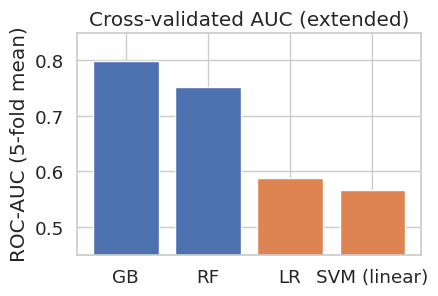

In [40]:
# (Optional) 1 small bar plot for extended CV AUCs
import matplotlib.pyplot as plt

cv_ext = {
    "GB": 0.799, "RF": 0.752, "LR": 0.589, "SVM (linear)": 0.567
}
plt.figure(figsize=(4.6,3.2))
plt.bar(list(cv_ext.keys()), list(cv_ext.values()), color=["#4C72B0","#4C72B0","#DD8452","#DD8452"])
plt.ylim(0.45, 0.85)
plt.ylabel("ROC-AUC (5-fold mean)")
plt.title("Cross-validated AUC (extended)")
plt.tight_layout(); plt.show()


optional

why: I run 5-fold stratified CV for all four models on core/extended sets. Stratification preserves the ~31% event rate in each fold. Using ROC-AUC and macro-F1 ensures both discrimination and class-balance are assessed. This validates models beyond the single train/test split.



[Report note: §III.C Evaluation methodology (5-fold stratified CV, metrics); §IV.A Results (CV comparison table + optional bar plot).]

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Brier score (lower is better): 0.167
Log loss (lower is better):   0.510


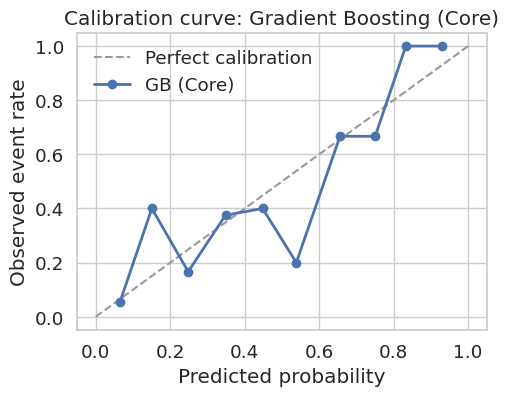

In [43]:
# 11A: Calibration curve for the best model (Gradient Boosting) on EXTENDED features
# Minimal: 80/20 split, median impute.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

# 1) pick the extended set , use this as primary in CV)
use_cols = core_cols = [c for c in core_cols if c in df_merged.columns]

X = df_merged[use_cols].apply(pd.to_numeric, errors="coerce").copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# 2) split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) impute (train median only)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i  = imp.transform(X_test)

# 4) train GB
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_i, y_train)

# 5) predicted probabilities on TEST
p_test = gb.predict_proba(X_test_i)[:, 1]

# 6) numeric calibration summary
brier = brier_score_loss(y_test, p_test)
ll    = log_loss(y_test, p_test)
print(f"Brier score (lower is better): {brier:.3f}")
print(f"Log loss (lower is better):   {ll:.3f}")

# 7) reliability curve (10 bins)
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")

# 8) plot (clean clinical style)
plt.figure(figsize=(5.2,4.2))
plt.plot([0,1],[0,1], "--", lw=1.5, color="#999999", label="Perfect calibration")
plt.plot(prob_pred, prob_true, marker="o", lw=2, label="GB (Core)", color="#4C72B0")
plt.xlabel("Predicted probability")
plt.ylabel("Observed event rate")
plt.title("Calibration curve: Gradient Boosting (Core)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


why: I check calibration for Gradient Boosting (our best model) using 80/20 split and median imputation. The Brier score and log-loss give numeric calibration, while the reliability curve shows how predicted risks match observed outcomes.



[Report note: §IV.A Results, calibration analysis for the best model (GB, extended).]

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lactate_val']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/di

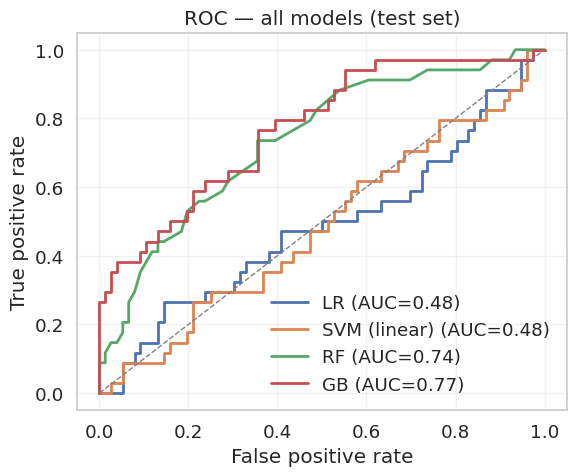

In [45]:
# ROC — all models on the same 80/20 split (minimal, self-contained)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# pick features (use extended for the final figure; swap to core_cols if you want)
feat_cols = [c for c in ext_cols if c in df_merged.columns]

# X / y (force numeric; leave NaN for imputer)
X = df_merged[feat_cols].apply(pd.to_numeric, errors="coerce").copy()
y = df_merged["outcome_dtx1yr"].astype(int).copy()

# one split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# each model has its own correct preprocessing inside the pipeline
models = {
    "LR": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(solver="liblinear", max_iter=1000, class_weight="balanced", random_state=42))
    ]),
    "SVM (linear)": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("clf", SVC(kernel="linear", probability=True, random_state=42))
    ]),
    "RF": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "GB": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
}

plt.figure(figsize=(6,5))
for name, pipe in models.items():
    pipe.fit(X_tr, y_tr)
    y_prob = pipe.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    auc = roc_auc_score(y_te, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "--", color="gray", lw=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC — all models (test set)")
plt.legend(frameon=False)
plt.grid(alpha=0.25)
plt.tight_layout(); plt.show()


why: I re-fit all four models with their own preprocessing and plot ROCs on the same split.

intended report note: §IV.A Results, combined ROC figure. Calibration curves included; confusion matrices considered but not shown for time contraints

**All references:**

McKinney, W., 2017. Python for data analysis: Data wrangling with Pandas, NumPy, and IPython. 2nd ed. O’Reilly Media.

VanderPlas, J., 2016. Python Data Science Handbook. O’Reilly Media.

Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. 2nd ed. O’Reilly Media.

Brownlee, J., 2020. Ordinal and One-Hot Encodings for Categorical Data. MachineLearningMastery, 17 August. Available at: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
 [Accessed 27 July 2025].

Machine Learning Tutorial Python – 6: Dummy Variables & One-Hot Encoding. YouTube video. Available at: YouTube. [Accessed 07 August 2025].

Variable Encodings for Machine Learning | Categorical, One-Hot, Dummy, Ordinal | ML Fundamentals. YouTube video. Available at: YouTube. [Accessed 05 August 2025].

Dummy variable (statistics). Wikipedia. Available at: https://en.wikipedia.org/wiki/Dummy_variable_(statistics)
 [Accessed 02 August 2025].

Categorical variable. Wikipedia. Available at: https://en.wikipedia.org/wiki/Categorical_variable
 [Accessed 03 August 2025].

Little, R.J.A. and Rubin, D.B., 2019. Statistical Analysis with Missing Data. 3rd ed. Wiley.
(academic justification that median/mode imputation is acceptable in small datasets).

Kuhn, M. and Johnson, K., 2013. Applied Predictive Modeling. Springer.
(clearly states why tree methods don’t need feature scaling, but LR/SVM do).

He, H. and Garcia, E., 2009. Learning from Imbalanced Data. IEEE Transactions on Knowledge and Data Engineering, 21(9), pp.1263–1284.

Data School, 2015. Cross-validation in scikit-learn. YouTube video. Available at: https://www.youtube.com/watch?v=6dbrR-WymjI
 [Accessed 10 August 2025].

Scikit-learn, n.d. Probability calibration (calibration curves, Brier, log-loss). Scikit-learn documentation. Available at: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
 [Accessed 24 August 2025].

University of the West of England, 2024. Machine Learning & Predictive Analytics (UFCFXQ-15-M): Lecture notes and Demos. UWE Bristol.